# Mean-Variance MDPとNP困難

参考：
* [Mean-Variance Optimization in Markov Decision Processes](https://arxiv.org/abs/1104.5601)

MDPの目的は一般に累積報酬和の**期待値**を最大化することを目的にしますが，実応用では期待値だけの最大化では不十分なケースがあります．
累積報酬和の分散が大きいと，デプロイごとに性能にバラついてしまい，製品として販売するには困ります．

Mean-variance MDPは次の問題を考えます．

---

**Mean-variance MDP**

方策$\pi$の累積報酬和の期待値を$J_\pi$とし，その分散を$V_\pi$とする．
与えられたMDPと定数$\lambda$, $v$のもとで，$J_\pi \geq \lambda$かつ$V_\pi \leq v$を保証する$\pi$は存在するか？

---

実はこれはNP困難になります．証明しましょう．

## Mean-Variance MDPはNP困難

Mean-Variance MDPにおいて，分散が０になる方策を見つけるのがNP困難であることを，３−SAT問題を使って証明します．
３−SAT問題については[RL_CMDP_feasibility_NP_hard.ipynb](RL_CMDP_feasibility_NP_hard.ipynb)などを参照してください．

---

**３−SAT問題**
* $n$個のリテラル：$x_1, x_2, \dots, x_n$．例えば$x_3 = \text{true}$．
* $m$個の節：$C_1, C_2, \dots, C_n$．例えば$C_3=x_2 \vee \bar{x}_5 \vee x_7$．

このときに，$C_1\wedge C_2 \wedge \dots \wedge C_n$を満たすようにリテラルに$\text{true}$，$\text{false}$を入れることはできるか？がNP困難です．

---

次のMDPを考えましょう．

* 状態集合：$\{s_0, d_0, c_1, \dots, c_m, y_1, \dots, y_n\}$
    * 状態$c_i$が節$C_i$に相当します．
    * 状態$y_i$はリテラル$x_i$に相当します．
    * 状態$d_0$は吸収状態です
    * 状態$s_0$は初期状態です

* 遷移と報酬：
    * 行動に関わらず，$s_0$から$d_0, c_1, \dots, c_m$に確率$1/(m+1)$に遷移します．このときに報酬は発生しません．
    * 各$c_i$での遷移と報酬．
        * 各$c_i$は節に対応するため，$C_j$における３つのリテラルが割り当てられています．
        * $c_i$では，３つのリテラルに対応した状態に進むような３つの行動を取ることができます．
            * 例えば３つのリテラルが$x_1, \bar{x}_4, x_5$の場合，３つの行動はそれぞれ$y_1, y_4, y_5$に遷移します．
        * もし遷移したリテラルがnegatedな場合，つまり$\bar{x}$みたいな場合，-1の報酬が発生します．unnegatedな場合は+1の報酬が発生します．
    * 各$y_i$での遷移と報酬．
      * 各$y_i$では２つの行動$a_i$と$b_i$を選択することができます．
      * $a_i$を選ぶと+1，$b_i$を選ぶと-1の報酬が返ります．

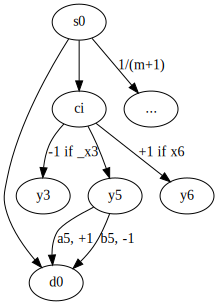

In [9]:
# 状態と遷移の関係．行動は固定されてることに注意

from graphviz import Digraph

g = Digraph('G')

g.node("s0")
g.node("d0")

g.edge("s0", "ci")
g.edge("s0", "...", label="1/(m+1)")
g.edge("s0", "d0")

g.edge("ci", "y3", label="-1 if _x3")
g.edge("ci", "y5")
g.edge("ci", "y6", label="+1 if x6")

g.edge("y5", "d0", label="a5, +1")
g.edge("y5", "d0", label="b5, -1")
g

---

**３−SATから方策へ**

以下，３−SAT問題の答えがtrueであるとして，次の方策を考えてみましょう．つまり，全ての節をtrueにするようなリテラルへのバイナリが存在します．

* 状態$c_i$では，節$C_i$をtrueにするような行動を取るとします．全ての節はtrueなので，各$C_i$には必ず一つリテラルがtrueになるような状態$y_\square$が存在します．
* このとき，リテラル$x_i$がunnegatedであれば，+1の報酬が発生します．
* 状態$y_i$ではリテラル$x_i$がunnegatedであれば，行動$b_i$を取るとします．このとき-1の報酬が発生します．
    * neggatedなときは$a_i$を取るとします．

このとき，発生する報酬和は常に$1 - 1 = 0$なので，リターンの分散は確率１で０になります．

---

**方策から３−SATへ**

このとき，mean-variance MDPは解けるでしょうか？

mean-variance MDPにおいて，分散を０にする方策が存在するとします．
このとき，$s_0$で$d_0$に遷移する可能性があるため，分散を０に維持するには，このMDPにおけるReturnは常に０である必要があります．

次のようにリテラルにtrueとfalseを割り当ててみましょう．
方策が$y_i$において$\pi(b_i\mid y_i) > 0$であれば，$x_i=\text{true}$とします．

例えばまず状態が$c_i$に遷移し，その後で方策によって状態$y_i$に遷移したとします．
$x_i$のリテラルがunnegatedであるとしましょう．すると，分散が０なので，$y_i$では必ず$b_i$を選択します．
このとき，$y_i$では$b_i$が選択されるので，$x_i$はtrueです．
よって，$C_i$もtrueになります．

同様にして，$x_i$がneggatedなときも$C_i$がtrueになります．

これより，全ての$C_i$がtrueになるので，3-SAT問題が解けることになります．

---

３−SAT問題はNP困難なので，以上から，mean-variance MDPはstrongly NP-hardであることがわかります．
